## Import & Data Load

In [78]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

train = pd.read_csv('train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('test.csv').drop(columns=['SAMPLE_ID'])

### 결측치 확인

In [79]:
train.isnull().sum().head(5)

ARI_CO                0
ARI_PO                0
SHIP_TYPE_CATEGORY    0
DIST                  0
ATA                   0
dtype: int64

In [80]:
train.columns

Index(['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ATA', 'ID',
       'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
       'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',
       'ATA_LT', 'DUBAI', 'BRENT', 'WTI', 'BDI_ADJ', 'PORT_SIZE', 'CI_HOUR'],
      dtype='object')

In [81]:
missing_air_temperature = train[train['AIR_TEMPERATURE'].isnull()]
missing_air_temperature['AIR_TEMPERATURE']

5        NaN
8        NaN
9        NaN
10       NaN
11       NaN
          ..
367427   NaN
367428   NaN
367432   NaN
367435   NaN
367436   NaN
Name: AIR_TEMPERATURE, Length: 154365, dtype: float64

In [82]:
missing_air_temperatures = train[['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']]
missing_air_temperatures.head()

missing_air_temperatures.fillna(0)
missing_air_temperatures



,U_WIND,V_WIND,AIR_TEMPERATURE,BN
0,0.14,3.77,15.9,2.730798
1,-3.16,-6.72,24.5,4.289058
2,0.00,0.00,9.4,0.000000
3,4.34,-7.31,22.1,4.693735
4,1.92,2.31,22.8,2.345875
...,...,...,...,...
367436,NaN,NaN,NaN,NaN
367437,-0.06,0.87,17.1,1.028558
367438,-0.63,3.36,31.7,2.557156
367439,3.74,-2.44,10.8,3.055715


In [83]:
test.isnull().sum().head()

ARI_CO                0
ARI_PO                0
SHIP_TYPE_CATEGORY    0
DIST                  0
ATA                   0
dtype: int64

## Data Pre-processing

In [84]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 
                        'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# # 결측치 처리
# train.fillna(train.mean(), inplace=True)
# test.fillna(train.mean(), inplace=True)


Encoding features: 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


### 결측치 데이터만 따로 테이블만들기

In [85]:
missing_air_temperatures = train[['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',"year","month","day"]]
missing_air_temperatures.head()
print(missing_air_temperatures.isnull().sum())

U_WIND             153486
V_WIND             153486
AIR_TEMPERATURE    154365
BN                 153486
year                    0
month                   0
day                     0
dtype: int64


### 결측치 데이터에서 null 값 0으로 채우기 (이유는 시간으로 정렬해서 이게 어떤 시간이 null인지 확인 위함)

In [86]:
missing_air_temperatures.fillna(0)
missing_air_temperatures.head()

,U_WIND,V_WIND,AIR_TEMPERATURE,BN,year,month,day
0,0.14,3.77,15.9,2.730798,2020,10,15
1,-3.16,-6.72,24.5,4.289058,2019,9,17
2,0.00,0.00,9.4,0.000000,2019,2,23
3,4.34,-7.31,22.1,4.693735,2020,9,18
4,1.92,2.31,22.8,2.345875,2022,8,13


### 결측치 데이터 시각화

C:\Users\User\AppData\Local\Temp\ipykernel_10648\3778912160.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_air_temperatures['date'] = pd.to_datetime(missing_air_temperatures[['year', 'month', 'day']])


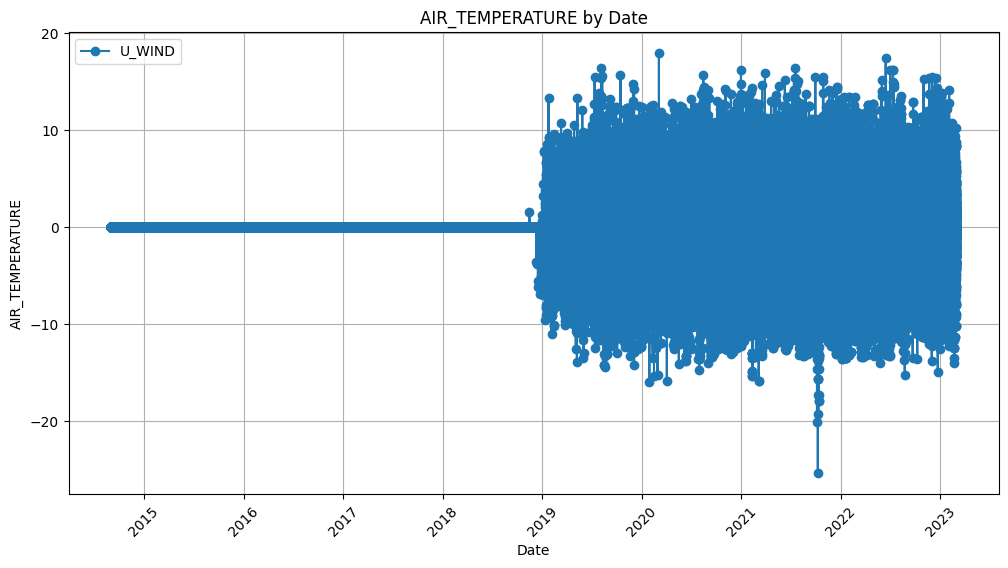

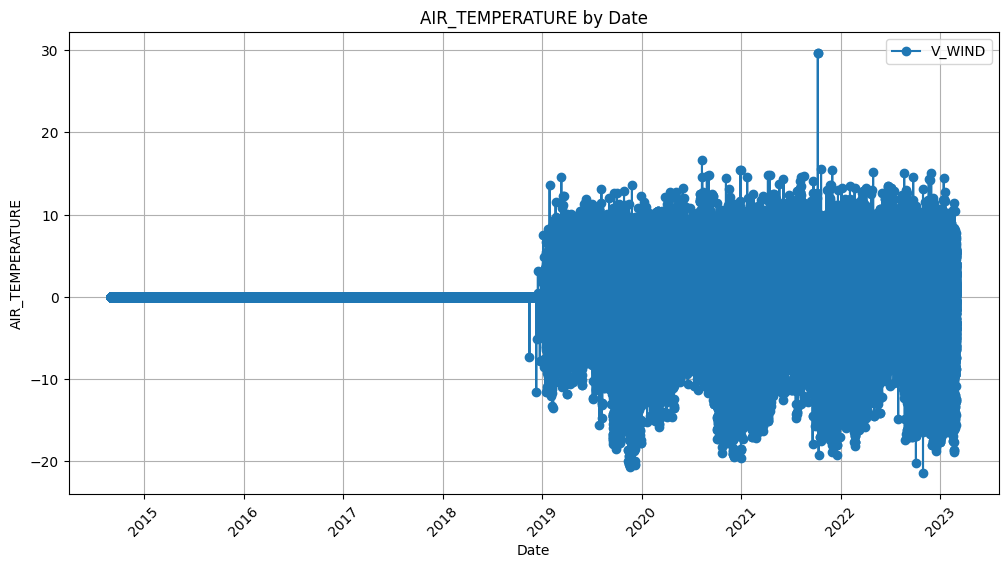

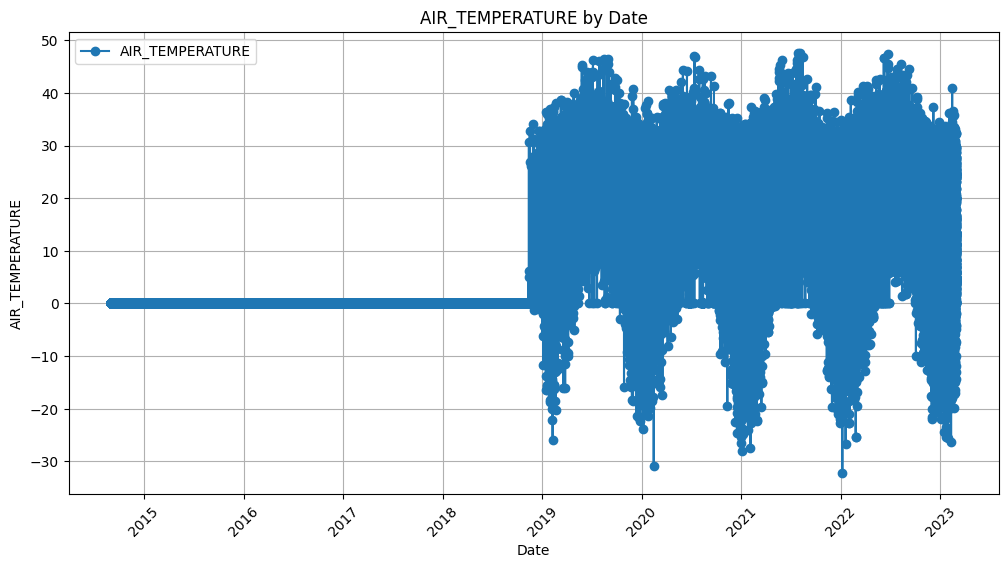

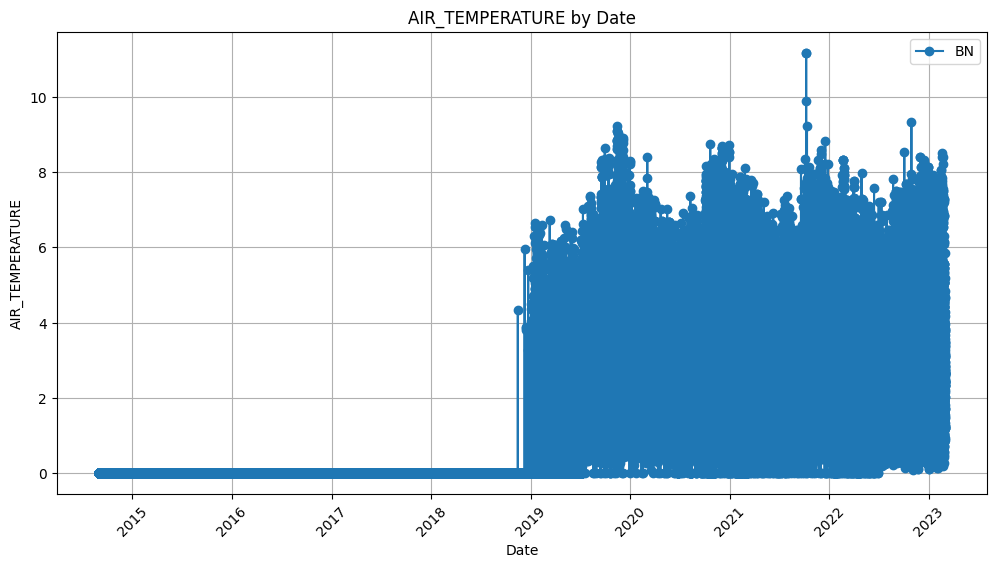

In [87]:
import matplotlib.pyplot as plt

# 'year', 'month', 'day'를 기반으로 날짜 열 생성
missing_air_temperatures['date'] = pd.to_datetime(missing_air_temperatures[['year', 'month', 'day']])

# 날짜를 기준으로 데이터 정렬
missing_air_temperatures = missing_air_temperatures.sort_values(by='date')

# 결측치를 0으로 채우기 (fillna 메서드를 사용하려면 결과를 새로운 변수에 할당해야 합니다)
missing_air_temperatures_filled = missing_air_temperatures.fillna(0)

feature = ['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']

for i in feature :
    # 시각화 
    plt.figure(figsize=(12, 6))
    plt.plot(missing_air_temperatures_filled['date'], missing_air_temperatures_filled[i], label= i, marker='o')
    plt.xlabel('Date')
    plt.ylabel('AIR_TEMPERATURE')
    plt.title('AIR_TEMPERATURE by Date')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()


### 결측치 데이터 이전 정보로 채우기

In [88]:
# # import pandas as pd

# # # 작년 데이터를 포함한 데이터프레임 생성 (예: train 데이터와 동일한 구조)
# # # 작년 데이터는 'year'를 1 감소시키면서 생성합니다.
# # last_year_data = train.copy()
# # last_year_data['year'] -= 1

# # # 결측치를 채울 함수 정의
# # def fill_missing_values(row):
# #     # 결측치가 있는 행 확인
# #     if pd.isnull(row['U_WIND']) or pd.isnull(row['V_WIND']) or pd.isnull(row['AIR_TEMPERATURE']) or pd.isnull(row['BN']):
# #         year = row['year']
# #         month = row['month']
# #         day = row['day']
        
# #         # 작년 동일한 month와 day를 가진 데이터 찾기
# #         last_year_same_date_data = last_year_data[(last_year_data['year'] == year) & (last_year_data['month'] == month) & (last_year_data['day'] == day)]
        
# #         if len(last_year_same_date_data) > 0:
# #             # 평균을 계산하여 결측치 채우기
# #             row['U_WIND'] = last_year_same_date_data['U_WIND'].mean()
# #             row['V_WIND'] = last_year_same_date_data['V_WIND'].mean()
# #             row['AIR_TEMPERATURE'] = last_year_same_date_data['AIR_TEMPERATURE'].mean()
# #             row['BN'] = last_year_same_date_data['BN'].mean()
    
# #     return row

# # # 결측치를 채우기 위해 각 행에 함수 적용
# # train = train.apply(fill_missing_values, axis=1)



# import pandas as pd

# # # 결측치를 채울 함수 정의
# # def fill_missing_values(row):
# #     # 결측치가 있는 행 확인
# #     if pd.isnull(row['U_WIND']) or pd.isnull(row['V_WIND']) or pd.isnull(row['AIR_TEMPERATURE']) or pd.isnull(row['BN']):
# #         year = row['year']
# #         month = row['month']
# #         day = row['day']
        
# #         # 현재 년도에서 이전 년도로 이동하며 결측치를 채우기
# #         while year >= 2019:  # 2020년부터 2023년까지 데이터가 있는 경우
# #             # 현재 년도에서 1 년을 감소시킵니다.
# #             year += 1
            
# #             # 현재 년도에서 결측치를 채울 데이터를 찾습니다.
# #             data_to_fill = train[(train['year'] == year) & (train['month'] == month) & (train['day'] == day)]
            
# #             if len(data_to_fill) > 0:
# #                 # 평균을 계산하여 결측치 채우기
# #                 row['U_WIND'] = data_to_fill['U_WIND'].mean()
# #                 row['V_WIND'] = data_to_fill['V_WIND'].mean()
# #                 row['AIR_TEMPERATURE'] = data_to_fill['AIR_TEMPERATURE'].mean()
# #                 row['BN'] = data_to_fill['BN'].mean()
# #                 break  # 결측치가 채워지면 루프 종료
    
# #     return row


# import pandas as pd

# # 결측치를 채울 함수 정의
# def fill_missing_values(row):
#     # 결측치가 있는 행 확인
#     if pd.isnull(row['U_WIND']) or pd.isnull(row['V_WIND']) or pd.isnull(row['AIR_TEMPERATURE']) or pd.isnull(row['BN']):
#         year = row['year']
#         month = row['month']
#         day = row['day']
        
#         # 2020년부터 2021년까지의 데이터를 가져옵니다.
#         data_to_fill = train[
#             (train['year'] >= 2020) & (train['year'] <= 2021) &
#             (train['month'] == month) & (train['day'] == day)
#         ]
        
#         if len(data_to_fill) > 0:
#             # 평균을 계산하여 결측치 채우기
#             row['U_WIND'] = data_to_fill['U_WIND'].mean()
#             row['V_WIND'] = data_to_fill['V_WIND'].mean()
#             row['AIR_TEMPERATURE'] = data_to_fill['AIR_TEMPERATURE'].mean()
#             row['BN'] = data_to_fill['BN'].mean()
    
#     return row

# # 결측치를 채우기 위해 각 행에 함수 적용
# train = train.apply(fill_missing_values, axis=1)
# test = test.apply(fill_missing_values, axis=1)

# # train 데이터를 CSV 파일로 저장
# train.to_csv('filleds_train_data.csv', index=False)

# # test 데이터를 CSV 파일로 저장
# test.to_csv('filleds_test_data.csv', index=False)


In [89]:

# 결측치를 채울 함수 정의
def fill_missing_values(row):
    # 결측치가 있는 행 확인
    if pd.isnull(row['U_WIND']) or pd.isnull(row['V_WIND']) or pd.isnull(row['AIR_TEMPERATURE']) or pd.isnull(row['BN']):
        year = row['year']
        month = row['month']
        day = row['day']
        
        # 2021년부터 2022년까지의 데이터를 가져옵니다.
        data_to_fill = train[
            (train['year'] >= 2021) & (train['year'] <= 2022) &
            (train['month'] == month) & (train['day'] == day)
        ]
        
        if len(data_to_fill) > 0:
            # 해당 데이터의 평균을 계산하여 결측치 채우기
            row['U_WIND'] = data_to_fill['U_WIND']
            row['V_WIND'] = data_to_fill['V_WIND']
            row['AIR_TEMPERATURE'] = data_to_fill['AIR_TEMPERATURE']
            row['BN'] = data_to_fill['BN']
    return row

# 결측치를 채우기 위해 각 행에 함수 적용
train = train.apply(fill_missing_values, axis=1)
test = test.apply(fill_missing_values, axis=1)

# train 데이터를 CSV 파일로 저장
train.to_csv('filledss_train_data.csv', index=False)

# test 데이터를 CSV 파일로 저장
test.to_csv('filledss_test_data.csv', index=False)



ValueError: setting an array element with a sequence.

In [90]:
import pandas as pd

# 결측치를 채울 함수 정의
def fill_missing_values(row):
    # 결측치가 있는 행 확인
    if pd.isnull(row['U_WIND']) or pd.isnull(row['V_WIND']) or pd.isnull(row['AIR_TEMPERATURE']) or pd.isnull(row['BN']):
        year = row['year']
        month = row['month']
        day = row['day']
        
        # 2021년부터 2022년까지의 데이터를 가져옵니다.
        data_to_fill = train[
            (train['year'] >= 2021) & (train['year'] <= 2022) &
            (train['month'] == month) & (train['day'] == day)
        ]
        
        if len(data_to_fill) > 0:
            # 해당 데이터의 평균을 계산하여 결측치 채우기
            row['U_WIND'] = data_to_fill['U_WIND'].mean()
            row['V_WIND'] = data_to_fill['V_WIND'].mean()
            row['AIR_TEMPERATURE'] = data_to_fill['AIR_TEMPERATURE'].mean()
            row['BN'] = data_to_fill['BN'].mean()
    return row

# 결측치를 채우기 위해 각 행에 함수 적용
train = train.apply(fill_missing_values, axis=1)
test = test.apply(fill_missing_values, axis=1)

# train 데이터를 CSV 파일로 저장
train.to_csv('filled_train_data.csv', index=False)

# test 데이터를 CSV 파일로 저장
test.to_csv('filled_test_data.csv', index=False)


KeyboardInterrupt: 

In [74]:
train.isnull().sum()

ARI_CO                0
ARI_PO                0
SHIP_TYPE_CATEGORY    0
DIST                  0
ID                    0
BREADTH               1
BUILT                 0
DEADWEIGHT            0
DEPTH                 1
DRAUGHT               1
GT                    0
LENGTH                1
SHIPMANAGER           0
FLAG                  0
U_WIND                0
V_WIND                0
AIR_TEMPERATURE       0
BN                    0
ATA_LT                0
DUBAI                 0
BRENT                 0
WTI                   0
BDI_ADJ               0
PORT_SIZE             0
CI_HOUR               0
year                  0
month                 0
day                   0
hour                  0
minute                0
weekday               0
dtype: int64

In [75]:
# train.fillna(train.mean(),inplace=True)
# test.fillna(train.mean(), inplace=True)

In [76]:
missing_air_temperaturess = train[['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',"year","month","day"]]
missing_air_temperaturess.head()
print(missing_air_temperaturess.isnull().sum())

U_WIND             0
V_WIND             0
AIR_TEMPERATURE    0
BN                 0
year               0
month              0
day                0
dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_10648\3347533304.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_air_temperaturess['date'] = pd.to_datetime(missing_air_temperaturess[['year', 'month', 'day']])


          U_WIND    V_WIND  AIR_TEMPERATURE        BN    year  month  day  \
16496  -0.241983  0.124283        24.657667  2.902757  2014.0    9.0  1.0   
119910 -0.241983  0.124283        24.657667  2.902757  2014.0    9.0  1.0   
66856  -0.241983  0.124283        24.657667  2.902757  2014.0    9.0  1.0   
56102  -0.241983  0.124283        24.657667  2.902757  2014.0    9.0  1.0   
71049  -0.241983  0.124283        24.657667  2.902757  2014.0    9.0  1.0   

             date  
16496  2014-09-01  
119910 2014-09-01  
66856  2014-09-01  
56102  2014-09-01  
71049  2014-09-01  


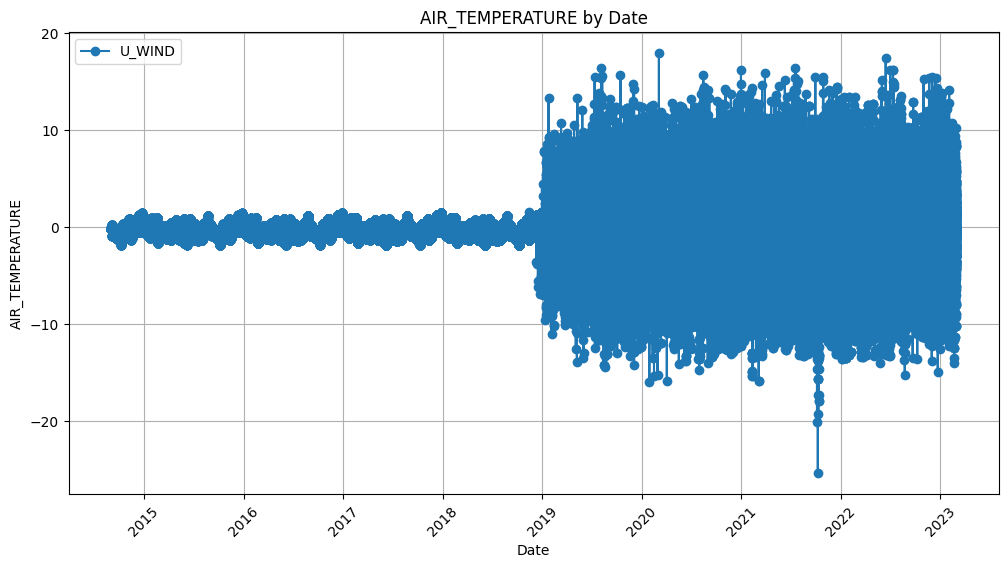

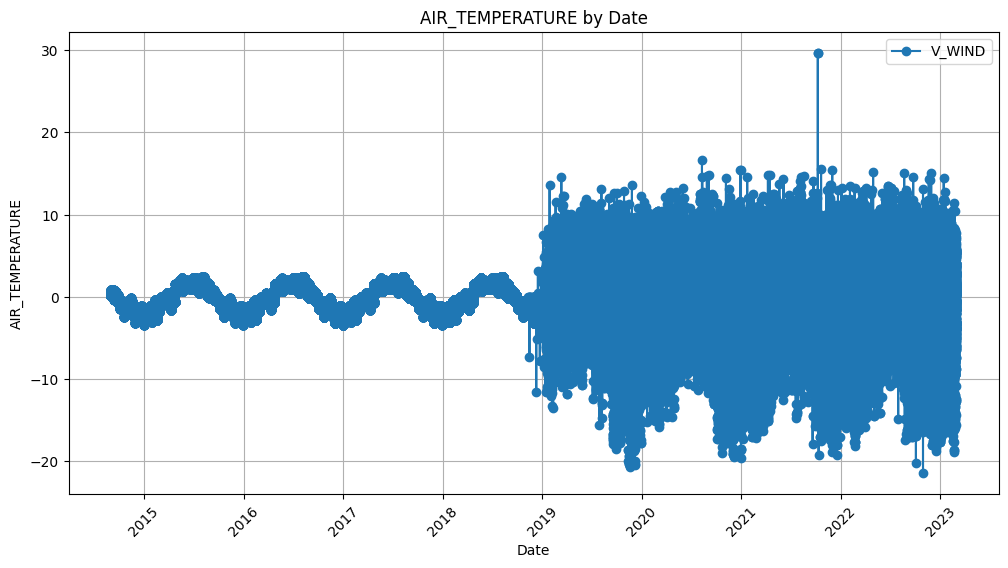

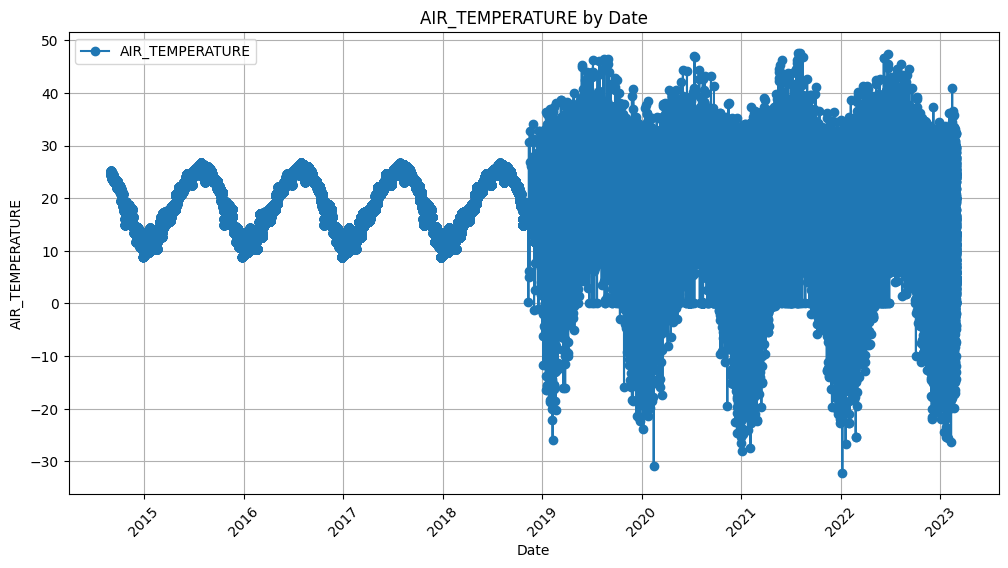

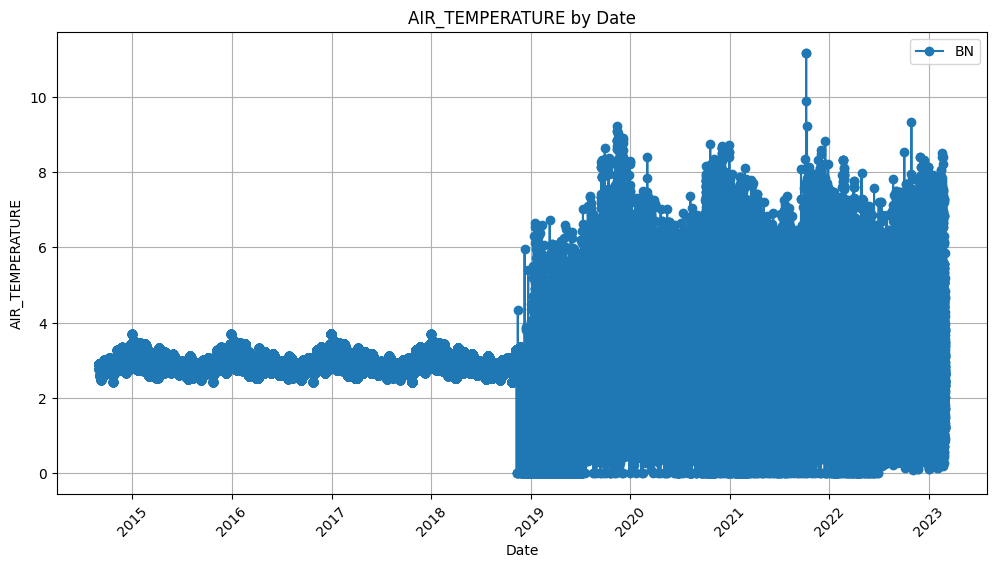

In [77]:
import matplotlib.pyplot as plt

# 'year', 'month', 'day'를 기반으로 날짜 열 생성
missing_air_temperaturess['date'] = pd.to_datetime(missing_air_temperaturess[['year', 'month', 'day']])

# 날짜를 기준으로 데이터 정렬
missing_air_temperaturess = missing_air_temperaturess.sort_values(by='date')
print(missing_air_temperaturess.head())
# 결측치를 0으로 채우기 (fillna 메서드를 사용하려면 결과를 새로운 변수에 할당해야 합니다)
missing_air_temperaturess_filled = missing_air_temperaturess

feature = ['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']

for i in feature :
    # 시각화 
    plt.figure(figsize=(12, 6))
    plt.plot(missing_air_temperaturess_filled['date'], missing_air_temperaturess_filled[i], label= i, marker='o')
    plt.xlabel('Date')
    plt.ylabel('AIR_TEMPERATURE')
    plt.title('AIR_TEMPERATURE by Date')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()


## CatBoostRegressor FEATURE SELECTION

Model Tune for CatBoostRegressor.


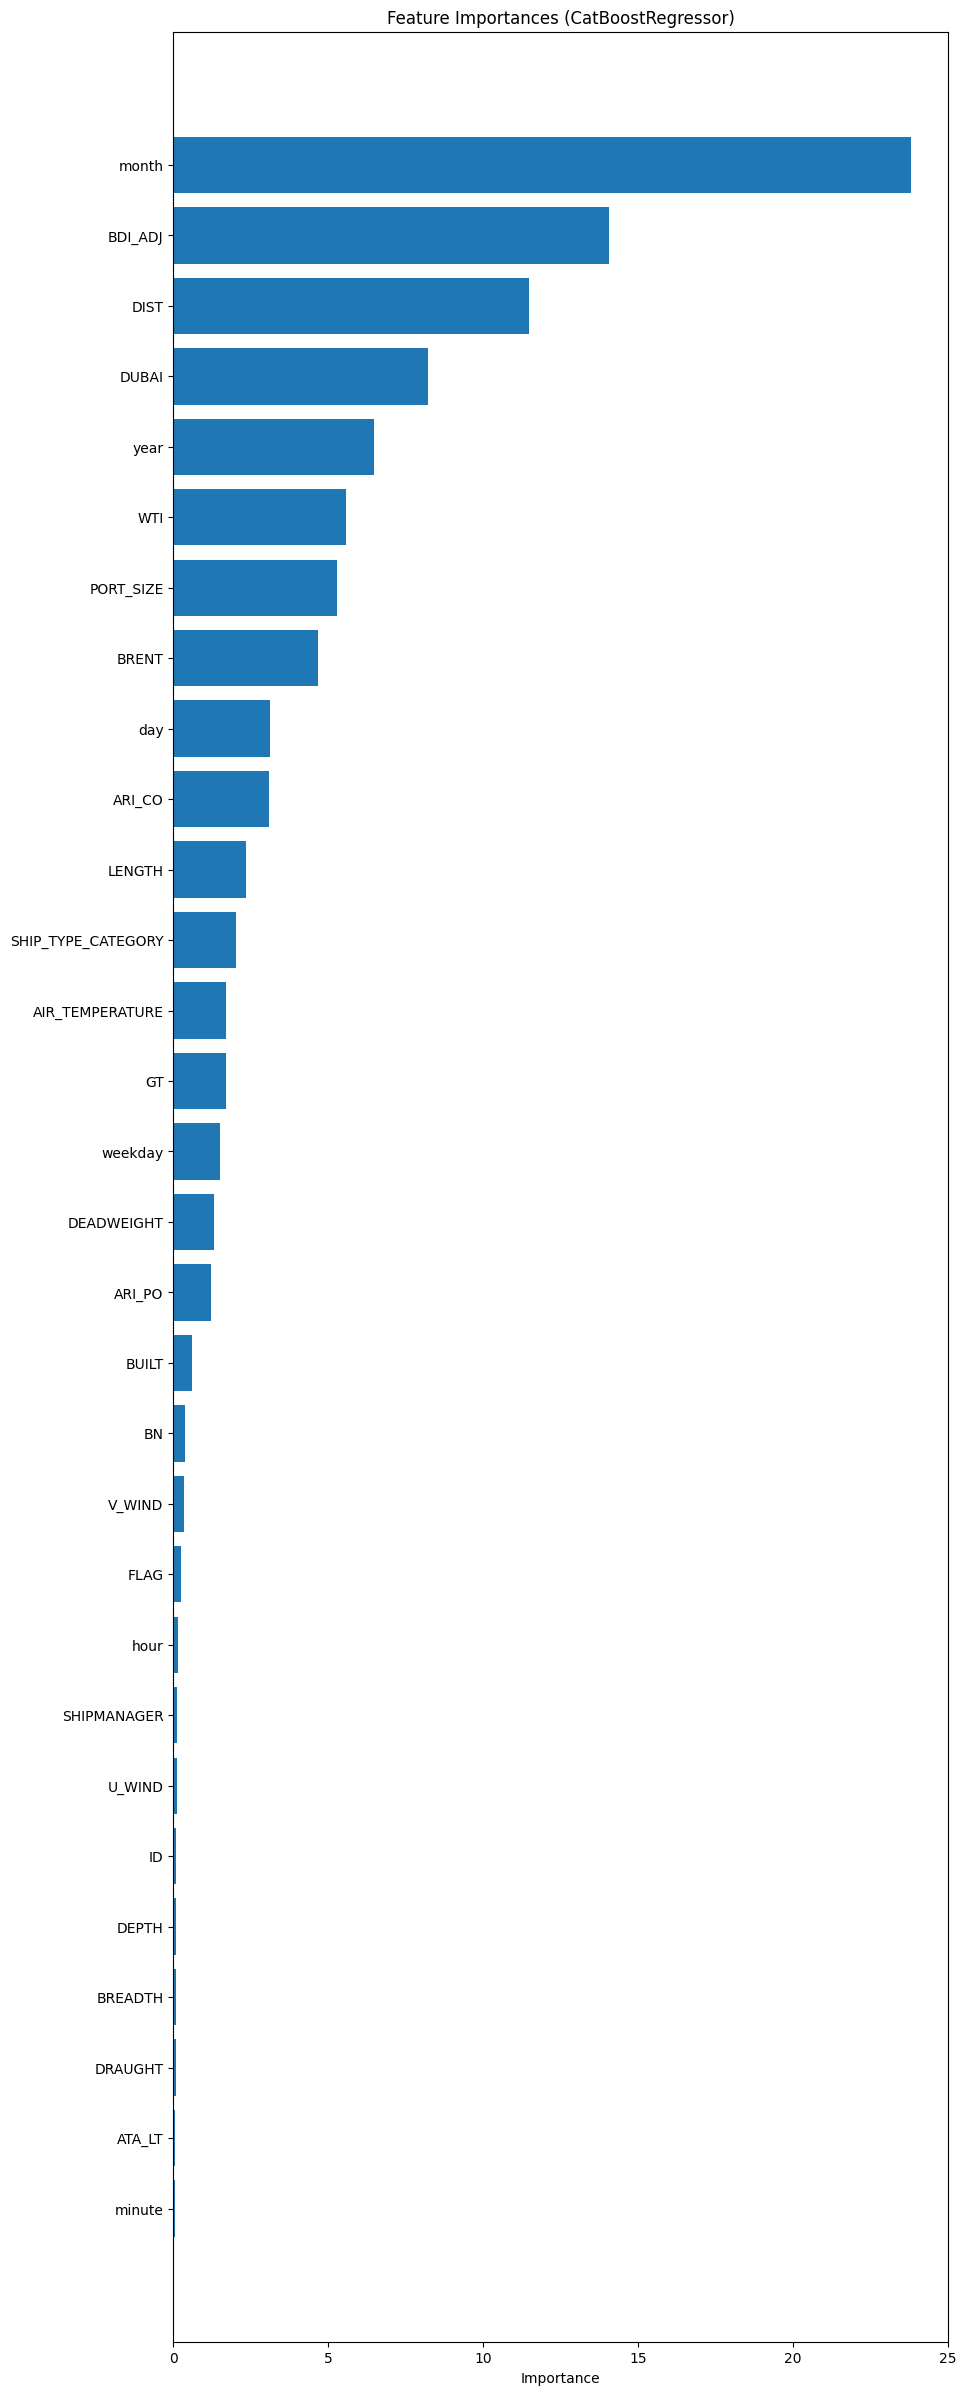

In [95]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from catboost import CatBoostRegressor


# 각 모델 학습 (이미 학습한 모델을 사용하려면 해당 부분을 제외하고 로드하세요)
catboost_model = CatBoostRegressor(random_state=42, loss_function= "RMSE", verbose=0)



def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)
    
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()
    
    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(catboost_model, 
                                                        'CatBoostRegressor', X_train, y_train)

In [98]:
threshold = 4.5 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

In [99]:
X_train_reduced.columns

Index(['DIST', 'DUBAI', 'BRENT', 'WTI', 'BDI_ADJ', 'PORT_SIZE', 'year',
       'month'],
      dtype='object')

## waprer

In [93]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# 가상의 데이터 생성
# X는 특성 데이터, y는 타겟 데이터

X = X_train 

y = y_train

# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# SBS 클래스 정의
class SBS():
    def __init__(self, estimator, k_features, scoring=mean_squared_error, test_size=0.25, random_state=1):
        self.scoring = scoring  # 성능 평가 지표
        self.estimator = clone(estimator)  # 회귀 모델 복제
        self.k_features = k_features  # 선택할 특성의 개수
        self.test_size = test_size  # 테스트 세트의 비율
        self.random_state = random_state  # 랜덤 시드 설정

    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        dim = X_train.shape[1]  # 전체 특성의 개수
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmin(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])

        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

# XGBoost 회귀 모델을 사용하여 SBS 수행
import xgboost as xgb

xgb_model = xgb.XGBRegressor(random_state=42)
sbs = SBS(estimator=xgb_model, k_features=1)
sbs.fit(X_train, y_train)

# 특성의 개수에 따른 성능 그래프 그리기
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.xlabel('Number of features')
plt.ylabel('Mean Squared Error')
plt.grid()
plt.show()


InvalidIndexError: (slice(None, None, None), (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29))

In [102]:
from sklearn.model_selection import StratifiedKFold
import optuna
import numpy as np
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor

X = X_train_reduced
y = y_train


def tune_model(model_type, X, Y, n_trials=500, cv=10):
    skf = StratifiedKFold(n_splits=cv)
    
    def objective(trial):
        params = {}
        
        if model_type == 'xgb':
            params['max_depth'] = trial.suggest_int('max_depth', 6, 16)
            params['learning_rate'] = trial.suggest_float('learning_rate', 0.05, 0.99)
            params['n_estimators'] = trial.suggest_int('n_estimators', 1000, 10000, step=10)
            params['colsample_bytree'] = trial.suggest_float('colsample_bytree', 0.5, 1.0)
            params['colsample_bylevel'] = trial.suggest_float('colsample_bylevel', 0.5, 1.0)
            params['colsample_bynode'] = trial.suggest_float('colsample_bynode', 0.5, 1.0)
            params['reg_lambda'] = trial.suggest_float('reg_lambda', 1e-2, 1, log=True)
            params['reg_alpha'] = trial.suggest_float('reg_alpha', 1e-2, 1, log=True)
            params['subsample'] = trial.suggest_float('subsample', 0.6, 1.0, step=0.05)
            params['min_child_weight'] = trial.suggest_int('min_child_weight', 2, 15)
            params['gamma'] = trial.suggest_float('gamma', 0.1, 1.0, log=True)
        
        elif model_type == 'cat':
            params['n_estimators'] = trial.suggest_int('n_estimators', 50, 5000)
            params['learning_rate'] = trial.suggest_loguniform('learning_rate', 0.03, 0.5)
            params['max_depth'] = trial.suggest_int('max_depth', 6, 12)
            params['reg_lambda'] = trial.suggest_loguniform('reg_lambda', 1e-4, 30)
            params['random_strength'] = trial.suggest_uniform('random_strength', 0.1, 30)
            params['bootstrap_type'] = trial.suggest_categorical('bootstrap_type', ['Bayesian'])
            params['bagging_temperature'] = trial.suggest_uniform('bagging_temperature', 0, 30)
        
        # Add more elif conditions for other model types if needed
        
        model = CatBoostRegressor(random_state=42, verbose=0, **params)
        score = cross_val_score(model, X, Y, cv=10, scoring='neg_mean_squared_error')
        rmse_score = np.sqrt(-1 * score)
        avg_rmse = rmse_score.mean()
        avg_std = rmse_score.std()
        print(avg_rmse, avg_std)
        return avg_rmse
    
    sampler = TPESampler(seed=42)
    study = optuna.create_study(direction='minimize', sampler=sampler)
    study.optimize(objective, n_trials=n_trials)
    print(f"Model: {model_type}, Best Score: {study.best_value}, Best Params: {study.best_params}")
    return study.best_params



# Example usage for CatBoost
best_params_cat = tune_model('cat', X, y, n_trials=500)


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2023-10-09 14:37:50,489] A new study created in memory with name: no-name-d9e03ca1-11ba-4557-b4df-6b89db37e7ea
C:\Users\User\AppData\Local\Temp\ipykernel_10648\4061967499.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  params['learning_rate'] = trial.suggest_loguniform('learning_rate', 0.03, 0.5)
C:\Users\User\AppData\Local\Temp\ipykernel_10648\4061967499.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log

KeyboardInterrupt: 

In [ ]:
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import ExtraTreesRegressor
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# from sklearn.linear_model import ElasticNet
# from sklearn.ensemble import AdaBoostRegressor, VotingRegressor
# from catboost import CatBoostRegressor, Pool
# from sklearn.experimental import enable_hist_gradient_boosting
# from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
# from sklearn.model_selection import cross_val_score

# X = X_train_reduced
# y = y_train
# # ex_rlf = ExtraTreesRegressor(random_state = 42)
# # lr_rlf = LinearRegression()
# # rg_rlf = Ridge()
# # rf_rlf = RandomForestRegressor(random_state = 42)
# gb_rlf = GradientBoostingRegressor(random_state = 42)
# xgb_rlf = xgb.XGBRegressor(random_state = 42)
# lgb_rlf = lgb.LGBMRegressor(random_state = 42)
# ada_rlf = AdaBoostRegressor(random_state = 42)
# cat_rlf = CatBoostRegressor(random_state = 42, loss_function = 'RMSE', verbose = 0)

# models = [ gb_rlf, xgb_rlf, lgb_rlf,
#          ada_rlf, cat_rlf] # ex_rlf, lr_rlf, rg_rlf, rf_rlf,

# print('====================================== 베이스 라인 모델 평가 ==========================================')
# for model in models:
#     cv_score = cross_val_score(model, X, y, cv = 2, scoring = 'neg_mean_squared_error')
#     mse_score = -1 * cv_score  # 음수로 출력되므로 양수로 변환
#     avg_mse = mse_score.mean()
#     avg_std = mse_score.std()
#     print('모델명 : {}  '.format(model.__class__.__name__), end = ' ')
#     print('평균 MSE : {0:.4f}, 표준편차 : {1:.4f}'.format(avg_mse, avg_std))


====================================== 베이스 라인 모델 평가 ==========================================
모델명 : GradientBoostingRegressor   평균 MSE : 23661.6781, 표준편차 : 188.1609
모델명 : XGBRegressor   평균 MSE : 13384.1923, 표준편차 : 401.1171
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1401
[LightGBM] [Info] Number of data points in the train set: 183720, number of used features: 8
[LightGBM] [Info] Start training from score 61.932258
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1401
[LightGBM] [Info] Number of data points in the train set: 183721, number of used features: 8
[LightGBM]

In [ ]:
## 아니면 널값 다 잘라버리자

## 모델 학습 및 특성 중요도 확인

## 특징 중요도로 부터 feature sections

In [503]:
X_train_reduced = train.drop(columns=['BREADTH', 'DEPTH', 'DRAUGHT', 'FLAG',
                                'BN', 'BRENT',  'year', 'weekday','CI_HOUR','LENGTH',
                                'SHIP_TYPE_CATEGORY','ARI_CO', 'ARI_PO'])
X_test_reduced = test.drop(columns=['BREADTH', 'DEPTH', 'DRAUGHT', 'FLAG',
                                'BN', 'BRENT', 'year', 'weekday','LENGTH',
                                'SHIP_TYPE_CATEGORY','ARI_CO', 'ARI_PO'])
y_train = train['CI_HOUR']

In [504]:
X_train_reduced.columns

Index(['DIST', 'ID', 'BUILT', 'DEADWEIGHT', 'GT', 'SHIPMANAGER', 'U_WIND',
       'V_WIND', 'AIR_TEMPERATURE', 'ATA_LT', 'DUBAI', 'WTI', 'BDI_ADJ',
       'PORT_SIZE', 'month', 'day', 'hour', 'minute'],
      dtype='object')

<!-- ### 'DIST', 'ID', 'BUILT', 'DEADWEIGHT', 'GT', 'SHIPMANAGER', 'U_WIND',
       'V_WIND', 'AIR_TEMPERATURE', 'ATA_LT', 'DUBAI', 'WTI', 'BDI_ADJ',
       'PORT_SIZE', 'month', 'day', 'hour', 'minute' -->

In [505]:
X_train_reduced.isnull().sum()

DIST               0
ID                 0
BUILT              0
DEADWEIGHT         0
GT                 0
SHIPMANAGER        0
U_WIND             0
V_WIND             0
AIR_TEMPERATURE    0
ATA_LT             0
DUBAI              0
WTI                0
BDI_ADJ            0
PORT_SIZE          0
month              0
day                0
hour               0
minute             0
dtype: int64

In [506]:
y_train.isnull().sum()

0

## 초기 하이퍼파라미터 찾는 모델

In [507]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split




X = X_train_reduced

y =  y_train


# 학습 데이터와 검증 데이터로 분할합니다.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Optuna를 사용하여 XGBoost 모델의 하이퍼파라미터 최적화를 수행하는 함수를 정의합니다.
def objective(trial):
    params = {
        "n_estimators" : trial.suggest_int('n_estimators', 3800, 8000),
        'max_depth':trial.suggest_int('max_depth', 15, 50),
        'min_child_weight':trial.suggest_int('min_child_weight', 15, 50),
        'gamma':trial.suggest_int('gamma', 1, 20),
        'learning_rate': 0.01,
        'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.5, 1, 0.1),
        'nthread' : -1,
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 30.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 30.0),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9, 1.0] ),
        'random_state': 42,
    }
    

    # XGBoost 모델을 생성합니다.
    model = xgb.XGBRegressor(**params)

    # 모델을 학습합니다.
    model.fit(X_train, y_train)

    # 검증 데이터로 예측을 수행합니다.
    y_pred = model.predict(X_valid)

    # 평균 제곱 오차(MSE)를 계산하여 최소화하도록 최적화합니다.
    mse = mean_absolute_error(y_valid, y_pred)

    return mse

# Optuna 스터디를 생성하고 실행합니다.
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials= 500)  # 시행 횟수를 지정할 수 있습니다.

# 최적화된 하이퍼파라미터와 MSE 값을 출력합니다.
best_params = study.best_params
best_mse = study.best_value
print("Best Hyperparameters:", best_params)
print("Best MAE:", best_mse)

'''Trial 99 finished with value: 74.81565301998755 and parameters: {'booster': 'gblinear', 'lambda': 0.9991204069558048, 'alpha': 0.00017832482509711246, 'max_depth': 9, 'eta': 0.06035489723871622, 'gamma': 4.7586518398906114e-07, 'grow_policy': 'depthwise'}. Best is trial 97 with value: 38.14362321762381.
Best Hyperparameters: {'booster': 'dart', 'lambda': 0.2770997780075583, 'alpha': 0.00018955177729168657, 'max_depth': 9, 'eta': 0.4883247068494185, 'gamma': 1.6754075326032887e-06, 'grow_policy': 'depthwise'}
Best MAE: 38.14362321762381'''

[I 2023-10-06 17:55:17,156] A new study created in memory with name: no-name-cff03564-bb60-45db-911c-f7bb27719dab
C:\Users\User\AppData\Local\Temp\ipykernel_12704\3137136614.py:26: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.5, 1, 0.1),
C:\Users\User\AppData\Local\Temp\ipykernel_12704\3137136614.py:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 30.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12704\3137136614.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.

KeyboardInterrupt: 

In [237]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# 1. 테스트 데이터 불러오기
test_data = X_test_reduced  # 테스트 데이터 파일 경로를 지정하세요.

# 2. 테스트 데이터 전처리 (필요한 전처리 과정을 X_test에 적용)
X_test = test_data # 테스트 데이터에서 'CI_HOUR' 열을 제외하거나 필요한 열만 선택
# 나머지 전처리 단계를 동일하게 적용 (예: 스케일링, 원핫 인코딩 등)

# 3. 랜덤 포레스트 모델을 사용하여 예측 수행
rf_pred = xgb_model.predict(X_test)

# # 예측 결과를 원하는 형식으로 저장하거나 활용할 수 있습니다.
# # 예를 들어, DataFrame으로 저장하고 CSV 파일로 내보낼 수 있습니다.
# predictions_df = pd.DataFrame({'Predicted_CI_HOUR': rf_pred})
# predictions_df.to_csv('predictions.csv', index=False)  # 예측 결과를 'predictions.csv' 파일로 저장


In [238]:
submit = pd.read_csv('./sample_submission.csv')

In [239]:
submit.head()

,SAMPLE_ID,CI_HOUR
0,TEST_000000,0
1,TEST_000001,0
2,TEST_000002,0
3,TEST_000003,0
4,TEST_000004,0


In [240]:
submit['CI_HOUR'] = rf_pred

In [241]:
submit.head()

,SAMPLE_ID,CI_HOUR
0,TEST_000000,72.079865
1,TEST_000001,441.817688
2,TEST_000002,0.682082
3,TEST_000003,7.271054
4,TEST_000004,89.438797


In [242]:
submit.to_csv('E:/ship/ship/models/baseline_submit_6_내일제출하자.csv', index=False)